-----------------------------------------------------------------------------------------------------------------

--------------- WELCOME TO THIS 'SPAM DETECTOR PROJECT', USING RNN, FINE-TUNING ----------------------------------

-----------------------------------------------------------------------------------------------------------------

-------------------- PART I : INSTALLING LIBRARIES, EXPLORATORY DATA ANALYSIS ---------------------------------

In [20]:
#!pip install pandas

Facing cache env issues I have to run this nb with two kernel. Not you :-)
Reminder : Use Kernel "tensorflow2_9(Python 3.8.18)" until part IV, use Kernel ".Conda new_tensor_env"  
for part IV

In [21]:
import pandas as pd

In [22]:
import os
import io
import warnings
import pathlib

In [23]:
#warnings.filterwarnings('ignore')

In [24]:
# OPENING CSV file
df=pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [25]:
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [26]:
nan_2 = df['Unnamed: 2'].isna().sum()
nan_3 = df['Unnamed: 3'].isna().sum()
nan_4 = df['Unnamed: 4'].isna().sum()

print("Nombre de NaN dans 'Unnamed: 2':", nan_2, "/", len(df['Unnamed: 2']))
print("Nombre de NaN dans 'Unnamed: 3':", nan_3, "/", len(df['Unnamed: 3']))
print("Nombre de NaN dans 'Unnamed: 4':", nan_4, "/", len(df['Unnamed: 4']))

Nombre de NaN dans 'Unnamed: 2': 5522 / 5572
Nombre de NaN dans 'Unnamed: 3': 5560 / 5572
Nombre de NaN dans 'Unnamed: 4': 5566 / 5572


we can in first approache drop those unuseless 3 cols :

In [27]:
df=df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [28]:
df.head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [29]:
# voyons si les catégories spam/non spam sont équilibrées:
category_counts = df['v1'].value_counts()

print(category_counts)

category_percentage = df['v1'].value_counts(normalize=True) * 100
print(category_percentage)

v1
ham     4825
spam     747
Name: count, dtype: int64
v1
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


Wow : This dataset is imbalanced !  
We'll have to use 'Randomoversampler' library to increase the 'spam' features to equilibrate the dataset.  
We could also modify weights during the training of our RNN to come.

In [34]:
#!pip install spacy
# passer par terminal

------------------------------- > PART II: PREPROCESSING TEXT DATAS WITH SPACY < --------------------------------

Let begin cleaning the text of v2 column with Spacy for english text

In [35]:
#!python -m spacy download en_core_web_sm

In [36]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [37]:
from spacy.lang.en.stop_words import STOP_WORDS

In [38]:
df["v2_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["v2_clean"] = df["v2_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["v2_clean"] = df["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [39]:
df.head()

,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [40]:
df.tail()

,v1,v2,v2_clean
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win å750 pound priz...
5568,ham,Will Ì_ b going to esplanade fr home?,ì b esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching act like interested buy week free
5571,ham,Rofl. Its true to its name,rofl true


Let's check if all values of v2_clean column are text ones :

In [41]:
mask = df.v2_clean.apply(lambda x: type(x)==str)
mask.value_counts()

v2_clean
True    5572
Name: count, dtype: int64

That's it.
In term of preprocessing we now define again df using mask filter :

In [42]:
df = df.loc[mask,:]

In [ ]:
#!pip install tensorflow==2.9

In [ ]:
#!pip install protobuf==3.20.*

In [43]:
!pip list

Package                      Version
---------------------------- ----------
absl-py                      2.1.0
annotated-types              0.6.0
asttokens                    2.4.1
astunparse                   1.6.3
backcall                     0.2.0
blis                         0.7.11
Brotli                       1.0.9
cachetools                   5.3.3
catalogue                    2.0.10
certifi                      2024.2.2
charset-normalizer           2.0.4
click                        8.1.7
cloudpathlib                 0.16.0
colorama                     0.4.6
comm                         0.2.2
confection                   0.1.4
cymem                        2.0.6
dataclasses                  0.8
debugpy                      1.8.1
decorator                    5.1.1
en-core-web-sm               3.5.0
executing                    2.0.1
filelock                     3.13.3
flatbuffers                  24.3.25
fsspec                       2024.3.1
gast                         0.4.0
goo

Here for a spam detector, we can use num_words=1000 as the used vocabulary is quite simple. Which reduces the entries dimensionality and so reduces complexity of model to be trained.
Then we create the "oov_token" string to replace any unknowned word, so our model keeps on running. 

-------------------------------------- > DATAS TOKENISATION < -----------------------------------------------

In [44]:
import numpy as np
import tensorflow as tf

In [76]:
from transformers import BertTokenizer

#Load pre-trained BERT model
model_name = 'bert-base-uncased'  # You can choose other variants too
tokenizer2 = BertTokenizer.from_pretrained(model_name)


In [125]:
max_length = 128
def tokenize_text(text):
    tokenized_output = tokenizer2(text, padding=True, truncation=True, max_length=max_length, return_tensors="tf")
    return tokenized_output['input_ids'][0].numpy()
#Apply the tokenizer function to each element in the 'v2_clean' column
encoded_sequences = df['v2_clean'].apply(tokenize_text)

#Add the encoded sequences as a new column 'v2_clean_encoded' to the DataFrame
df['v2_clean_encoded_bert'] = encoded_sequences


In [126]:
df.head()

,v1,v2,v2_clean,v2_clean_encoded,v2_clean_encoded_bert
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 230, 447, 464, 942, 32, 50, 204, 943, 78, ...","[101, 18414, 17583, 2391, 4689, 2800, 11829, 2..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 195, 465, 289, 2, 1]","[101, 7929, 2474, 2099, 8257, 15536, 2546, 105..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 533, 662, 30, 1, 849, 424, 1, 1, ...","[101, 2489, 4443, 1016, 1059, 2243, 2135, 4012..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 150, 1, 2, 79]","[101, 1057, 24654, 2220, 7570, 2099, 1057, 103..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[705, 20, 663, 129]","[101, 20976, 2228, 2149, 2546, 2444, 102]"


In [127]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab")
# for a spam detector coming from emails, num_words = 1000 could be enough


tokenizer.fit_on_texts(df.v2_clean)
df["v2_clean_encoded"] = tokenizer.texts_to_sequences(df.v2_clean)


In [128]:
df.head()

,v1,v2,v2_clean,v2_clean_encoded,v2_clean_encoded_bert
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 230, 447, 464, 942, 32, 50, 204, 943, 78, ...","[101, 18414, 17583, 2391, 4689, 2800, 11829, 2..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 195, 465, 289, 2, 1]","[101, 7929, 2474, 2099, 8257, 15536, 2546, 105..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 533, 662, 30, 1, 849, 424, 1, 1, ...","[101, 2489, 4443, 1016, 1059, 2243, 2135, 4012..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 150, 1, 2, 79]","[101, 1057, 24654, 2220, 7570, 2099, 1057, 103..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[705, 20, 663, 129]","[101, 20976, 2228, 2149, 2546, 2444, 102]"


In [129]:
df.v2_clean_encoded_bert[0]

array([  101, 18414, 17583,  2391,  4689,  2800, 11829,  2483,  1050,
        2307,  2088,  2474,  1041, 28305, 25022,  2638, 26297, 28194,
         102])

Let's use "padding" to have same length sentences before going further.  
Especially "padding = post" to fill sentences's end rather than their beginning

In [130]:
v2_pad = tf.keras.preprocessing.sequence.pad_sequences(df.v2_clean_encoded, padding="post")
v2_pad=pd.Series(v2_pad.tolist())

In [131]:
df_model = df[['v1', 'v2_clean', 'v2_clean_encoded_bert']].copy()
df_model['v2_pad']=v2_pad
df_model.head()

,v1,v2_clean,v2_clean_encoded_bert,v2_pad
0,ham,jurong point crazy available bugis n great wor...,"[101, 18414, 17583, 2391, 4689, 2800, 11829, 2...","[1, 230, 447, 464, 942, 32, 50, 204, 943, 78, ..."
1,ham,ok lar joke wif u oni,"[101, 7929, 2474, 2099, 8257, 15536, 2546, 105...","[8, 195, 465, 289, 2, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,"[101, 2489, 4443, 1016, 1059, 2243, 2135, 4012...","[11, 300, 3, 533, 662, 30, 1, 849, 424, 1, 1, ..."
3,ham,u dun early hor u c,"[101, 1057, 24654, 2220, 7570, 2099, 1057, 103...","[2, 125, 150, 1, 2, 79, 0, 0, 0, 0, 0, 0, 0, 0..."
4,ham,nah think usf live,"[101, 20976, 2228, 2149, 2546, 2444, 102]","[705, 20, 663, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [53]:
#df_model=df[['v1', 'v2_clean']].copy()
#df_model['v2_pad']=v2_pad
#df_model.head()


------------------- Before creating tensor: transform v1 string column 'ham/spam' into numbers ------------

In [132]:
labels= {'spam':1, 'ham': 0}
df_model['v1'] = df_model['v1'].map(labels)
df_model.head()

,v1,v2_clean,v2_clean_encoded_bert,v2_pad
0,0,jurong point crazy available bugis n great wor...,"[101, 18414, 17583, 2391, 4689, 2800, 11829, 2...","[1, 230, 447, 464, 942, 32, 50, 204, 943, 78, ..."
1,0,ok lar joke wif u oni,"[101, 7929, 2474, 2099, 8257, 15536, 2546, 105...","[8, 195, 465, 289, 2, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,free entry 2 wkly comp win fa cup final tkts 2...,"[101, 2489, 4443, 1016, 1059, 2243, 2135, 4012...","[11, 300, 3, 533, 662, 30, 1, 849, 424, 1, 1, ..."
3,0,u dun early hor u c,"[101, 1057, 24654, 2220, 7570, 2099, 1057, 103...","[2, 125, 150, 1, 2, 79, 0, 0, 0, 0, 0, 0, 0, 0..."
4,0,nah think usf live,"[101, 20976, 2228, 2149, 2546, 2444, 102]","[705, 20, 663, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
#!pip install scikit-learn==1.3.2

Quite ready for creating model : next steps are train test split, equilibrate datas, then create tensor.

In [ ]:
#!pip install imbalanced-learn
# passé par le terminal avec conda

In [133]:
from sklearn.model_selection import train_test_split

In [136]:
X = df_model['v2_pad']
y = df_model['v1']

In [137]:
X_2 = df_model['v2_clean_encoded_bert'].to_numpy()
y_2 = df_model['v1'].to_numpy()

In [138]:
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# randomSampler needs to reshape before launch
#X_train = X_train.reshape(-1, 1) if len(X_train.shape) == 1 else X_train
#y_train = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train


# here we equilibrate the datas increasing the number of 'spam' category
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


In [139]:
# for Bert to come
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.1, random_state=42)

# press 'alt' + clic to duplicate modif 

X_train_2 = X_train_2.reshape(-1, 1) if len(X_train_2.shape) == 1 else X_train_2
y_train_2 = y_train_2.reshape(-1, 1) if len(y_train_2.shape) == 1 else y_train_2


# here we equilibrate the datas increasing the number of 'spam' category
ros = RandomOverSampler(random_state=42)
X_train_2_resampled, y_train_2_resampled = ros.fit_resample(X_train_2, y_train_2)

--------------------------------- PART III: CREATING A RNN MODEL -----------------------------------------------

In [140]:
type (X_train_resampled)

numpy.ndarray

In [141]:
type(y_train_resampled)

pandas.core.series.Series

In [142]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_resampled = np.array(X_train_resampled.tolist())
y_train_resampled = np.array(y_train_resampled)

# Our params:
max_features = 1000  # taille du vocabulaire
embedding_dim = 64  # dimension de l'espace vectoriel d'embedding

# Building model, some cooking inside...
model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(SimpleRNN(units=32, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Using a sigmoid function activation as our output is a binary choice : spam or no spam

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [143]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 67,649
Trainable params: 67,649
Non-trainable params: 0
_________________________________________________________________


In [144]:
history = model.fit(X_train_resampled, y_train_resampled, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10


217/217 [==============================] - 2s 7ms/step - loss: 0.1962 - accuracy: 0.9423 - val_loss: 0.1119 - val_accuracy: 0.9694
Epoch 2/10
217/217 [==============================] - 1s 7ms/step - loss: 0.0772 - accuracy: 0.9794 - val_loss: 0.1247 - val_accuracy: 0.9671
Epoch 3/10
217/217 [==============================] - 1s 7ms/step - loss: 0.1041 - accuracy: 0.9686 - val_loss: 0.0988 - val_accuracy: 0.9735
Epoch 4/10
217/217 [==============================] - 2s 7ms/step - loss: 0.0708 - accuracy: 0.9811 - val_loss: 0.0669 - val_accuracy: 0.9792
Epoch 5/10
217/217 [==============================] - 2s 7ms/step - loss: 0.0414 - accuracy: 0.9885 - val_loss: 0.0850 - val_accuracy: 0.9637
Epoch 6/10
217/217 [==============================] - 1s 7ms/step - loss: 0.0348 - accuracy: 0.9900 - val_loss: 0.0730 - val_accuracy: 0.9792
Epoch 7/10
217/217 [==============================] - 2s 7ms/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 0.0136 - val_accuracy: 0.9919
Epoch 8/10
217/21

Have a look on loss, accuracy with some graphs

In [145]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# For loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# For accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

In [146]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %f" % (model.metrics_names[0], scores[0]))


UnknownError: Graph execution error:

KeyError: '[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31] not in index'
Traceback (most recent call last):

  File "C:\Users\taver\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "C:\Users\taver\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "C:\Users\taver\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "C:\Users\taver\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\engine\data_adapter.py", line 513, in py_method
    return [slice_array(inp) for inp in flat_inputs]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\engine\data_adapter.py", line 513, in <listcomp>
    return [slice_array(inp) for inp in flat_inputs]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\engine\data_adapter.py", line 509, in slice_array
    return training_utils.slice_arrays(

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\engine\training_utils.py", line 52, in slice_arrays
    slices = generic_utils.slice_arrays(arrays, indices)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\utils\generic_utils.py", line 1199, in slice_arrays
    return [None if x is None else x[start] for x in arrays]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\utils\generic_utils.py", line 1199, in <listcomp>
    return [None if x is None else x[start] for x in arrays]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\series.py", line 1033, in __getitem__
    return self._get_with(key)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\series.py", line 1068, in _get_with
    return self.loc[key]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexing.py", line 1103, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexing.py", line 1332, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexing.py", line 1272, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexing.py", line 1462, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexes\base.py", line 5877, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexes\base.py", line 5941, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")

KeyError: '[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31] not in index'


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_test_function_207519]

Pretty good results, even if loss could be better.
We see that something happens after Epoch 7

Using F1score :

In [147]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

#F1 score:
score_f1 = f1_score(y_test, y_pred_classes)

print("F1 Score: %f" % score_f1)

18/18 [==============================] - 0s 2ms/step
F1 Score: 0.869565


This F1 score means our model learns from datas, but this can be improved.  
We could also try with other kinds of models : LSTM, GRU for example, better for long-term issue than RNN.

An idea, whenever:

In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


I'll see later with using GPU

Essai avec un batch-size plus élevé (64):

In [149]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history2 = model.fit(X_train_resampled, y_train_resampled, batch_size=64, epochs=20, validation_split=0.2, callbacks=[model_checkpoint_callback])


Epoch 1/20
 50/109 [============>.................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9972

109/109 [==============================] - 1s 9ms/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 0.0194 - val_accuracy: 0.9931
Epoch 2/20
109/109 [==============================] - 1s 8ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.0081 - val_accuracy: 0.9960
Epoch 3/20
109/109 [==============================] - 1s 8ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.0161 - val_accuracy: 0.9937
Epoch 4/20
109/109 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.0089 - val_accuracy: 0.9960
Epoch 5/20
109/109 [==============================] - 1s 8ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0040 - val_accuracy: 0.9960
Epoch 6/20
109/109 [==============================] - 1s 8ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.1028 - val_accuracy: 0.9723
Epoch 7/20
109/109 [==============================] - 1s 8ms/step - loss: 0.0197 - accuracy: 0.9961 - val_loss: 0.0130 - val_accuracy: 0.9937
Epoch 8/20
109/10

In [150]:
model_rnn_batch64 = tf.keras.models.load_model(checkpoint_filepath)

In [151]:
model_rnn_batch64.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 67,649
Trainable params: 67,649
Non-trainable params: 0
_________________________________________________________________


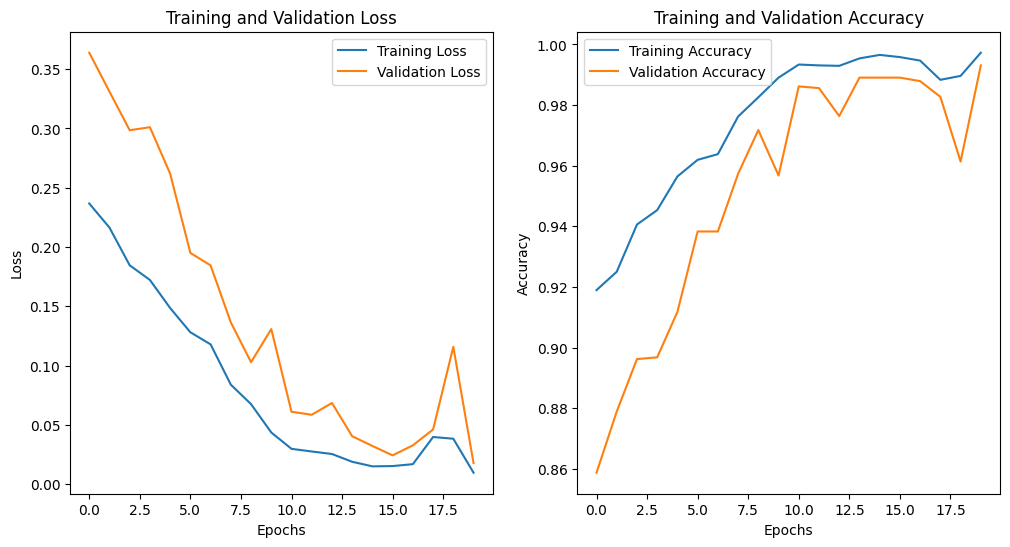

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

# Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [152]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %f" % (model.metrics_names[0], scores[0]))


UnknownError: Graph execution error:

KeyError: '[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31] not in index'
Traceback (most recent call last):

  File "C:\Users\taver\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "C:\Users\taver\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "C:\Users\taver\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "C:\Users\taver\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\engine\data_adapter.py", line 513, in py_method
    return [slice_array(inp) for inp in flat_inputs]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\engine\data_adapter.py", line 513, in <listcomp>
    return [slice_array(inp) for inp in flat_inputs]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\engine\data_adapter.py", line 509, in slice_array
    return training_utils.slice_arrays(

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\engine\training_utils.py", line 52, in slice_arrays
    slices = generic_utils.slice_arrays(arrays, indices)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\utils\generic_utils.py", line 1199, in slice_arrays
    return [None if x is None else x[start] for x in arrays]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\keras\utils\generic_utils.py", line 1199, in <listcomp>
    return [None if x is None else x[start] for x in arrays]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\series.py", line 1033, in __getitem__
    return self._get_with(key)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\series.py", line 1068, in _get_with
    return self.loc[key]

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexing.py", line 1103, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexing.py", line 1332, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexing.py", line 1272, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexing.py", line 1462, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexes\base.py", line 5877, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)

  File "c:\Users\taver\anaconda3\envs\new_tensor_env\lib\site-packages\pandas\core\indexes\base.py", line 5941, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")

KeyError: '[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31] not in index'


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_test_function_241720]

Better results !

F1 score: 

In [153]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

#F1 score:
score_f1 = f1_score(y_test, y_pred_classes)

print("F1 Score: %f" % score_f1)

18/18 [==============================] - 0s 2ms/step
F1 Score: 0.810811


This were better parameters for the RNN models we used.

----------------- PART IV : WHAT IF WE COULD IMPORT A PRETRAINED RNN, AND DO SOME TRANSFER TUNING ? ----------

Doing some transfer learning, is importing and using a pretrained model on internet, built by some  
university or big lab research with important hardware ressources.  
Have to choose one model pretrained with the same kind of fields we're working on : pictures, words...and  
just 'cut' the last layer.  
We replace then the last layer with our last one, as the output is specific to each project !

--------------------------------------- For example, using 'BERT' -----------------------------------

In [ ]:
#!pip install --upgrade tensorflow-hub

In [154]:
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import tensorflow_hub as hub

In [ ]:
#!pip install  tensorflow_text

In [155]:
import tensorflow_text

=> Facing many environnements issues I had to try things and fix lot of buggs.  
I let unused cells here as a reminder, just jump over them !

In [ ]:
# import os
# import sys

# model_dir = "C:/Users/taver/Documents/Jedha/Jedha_2023_2024/Bert"
# os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
# sys.modules['tensorflow_hub'] = hub
# bert_encoder = hub.load(model_dir)

In [ ]:

# model_dir = "C:/Users/taver/Documents/Jedha/Jedha_2023_2024/Bert_Preprocessor"
# os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
# sys.modules['tensorflow_hub'] = hub
# bert_preprocessor = hub.load(model_dir)

In [ ]:

#preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
#bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=False)
#text_preprocessed = bert_preprocessor(text_test)

# cache issue
# have to download 'Bert' on my laptop

In [1]:
#!pip install transformers

In [156]:
from transformers import BertConfig, TFBertModel

config = BertConfig.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config) 

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [165]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Tokenize the text data
def tokenize_text(text):
    return tokenizer2(text, padding=True, truncation=True, return_tensors="tf")['input_ids'][0]

df_model['tokenized_text'] = df_model['v2_clean'].apply(tokenize_text)

#Split the data into training and testing sets
train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42)

#Pad the tokenized sequences to a fixed length
max_length = 128  # Adjust as needed
train_inputs = pad_sequences(train_df['tokenized_text'], maxlen=max_length, dtype="long", padding="post", truncating="post")
test_inputs = pad_sequences(test_df['tokenized_text'], maxlen=max_length, dtype="long", padding="post", truncating="post")

#Convert labels into numpy arrays
train_labels = np.array(train_df['v1'])
test_labels = np.array(test_df['v1'])

In [172]:
train_masks = []

#For each sequence in train_inputs, create the corresponding attention mask
for seq in train_inputs:
    # Create a mask of 1s for each token followed by 0s for padding
    seq_mask = [float(i > 0) for i in seq]
    train_masks.append(seq_mask)

#Convert the lists of attention masks to numpy arrays
train_masks = np.array(train_masks)

In [178]:
#reshape
train_labels = tf.reshape(train_labels, (-1, 1))
train_masks = tf.cast(tf.not_equal(train_masks, 0), tf.int32)

In [179]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

#Define input layer
max_length = 128
input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

#Get BERT output
bert_output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]

#Add classification head
dense = Dense(256, activation='relu')(bert_output)
output = Dense(1, activation='sigmoid')(dense)

#Combine input and output to create model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

In [180]:
train_labels.shape

TensorShape([4457, 1])

In [181]:
train_inputs.shape

(4457, 128)

In [182]:
train_masks.shape

TensorShape([4457, 128])

In [183]:
#Freeze BERT layers
bert_model.trainable = False


#Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) # low learning rate as only last layer to train
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#X_train_2_resampled = tf.convert_to_tensor(X_train_2_resampled)
#y_train_2_resampled = tf.convert_to_tensor(y_train_2_resampled) 

#Train the model, only 3 epoch because last layer doesn't need more to learn
history = model.fit(x={'input_ids': train_inputs, 'attention_mask': train_masks}, y=train_labels, epochs=3, batch_size=32)

Epoch 1/3


140/140 [==============================] - 504s 4s/step - loss: 0.4726 - accuracy: 0.8078
Epoch 2/3
140/140 [==============================] - 527s 4s/step - loss: 0.2842 - accuracy: 0.8862
Epoch 3/3
140/140 [==============================] - 611s 4s/step - loss: 0.2214 - accuracy: 0.9111


------------------------------------ PART IV : FINE TUNING --------------------------------------

Fine tuning goes one step (...or more !) further than transfer learning.  
We keep our last layer plugged on an imported model, as with transfer learning.
Then going backward in layers, to choose how many of them we train to improve precision of our model.

In [ ]:
# Training some BERT layers

bert_model.trainable = False

# Unfreeze for example the last 5 layers
for layer in bert_model.layers[-5:]:
    layer.trainable = True

#Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#X_train_2_resampled = tf.convert_to_tensor(X_train_2_resampled)
#y_train_2_resampled = tf.convert_to_tensor(y_train_2_resampled) 

#Train the model, only 3 epoch because last layer doesn't need more to learn
history = model.fit(x={'input_ids': train_inputs, 'attention_mask': train_masks}, y=train_labels, epochs=20, batch_size=32)

In [ ]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(embeed['pooled_output'])

TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.string, name='Inputs'), name='Inputs', description="created by layer 'Inputs'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

In [ ]:
# creating final model
model_tlbert = tf.keras.Model(inputs = [text_input], outputs = [outputs])

NameError: name 'outputs' is not defined

In [ ]:
model_tlbert.summary()

: 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df_model['v2_clean'], df_model['v1'], test_size=0.1, random_state=42 )

: 

In [ ]:
model_tlbert.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_tlbert.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

: 

: 